In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import statsmodels.api as sm
import seaborn as sns
import math
from datetime import datetime
import matplotlib.ticker as ticker
from scipy.stats import pearsonr, spearmanr

/home/sara/.local/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_24844/4074614716.py:4: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (

In [2]:
disp_data = pd.read_excel(r"/home/sara/Documenti/GitHub/Climate-and-conflict/displacements/UNHCR-PRMN-Displacement-Dataset - Somalia.xlsx")
states_gdf = gpd.read_file(r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/som_adm_ocha_itos_20230308_shp/som_admbnda_adm1_ocha_20230308.shp")
df_d = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_lags_2016_n4_disp_fd.csv")
distance = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/dist_som.csv")

disp_data = disp_data[(disp_data['Reason']=='Drought related') | (disp_data['Reason']=='Flood')]
inv_distance = 1/distance
df_d['admin1'] = df_d['admin1'].str.replace('_',' ')

v= disp_data["Month End"]
v=v.values
dt = [datetime.strptime(v[i], "%d/%m/%Y") for i in range(len(v))]
q=[]
for i in range(len(dt)):
    q.append(datetime.timestamp(dt[i])) 
disp_data.insert(loc=3, column='date_timestamp', value=q)
disp_data = disp_data.sort_values("date_timestamp")
disp_data['Month End'] = pd.to_datetime(disp_data['Month End'], dayfirst=True)

aggregated_data = disp_data.groupby([pd.Grouper(key='Month End', freq='M'),'Previous (Departure) Region', 'Current (Arrival) Region'])['Number of Individuals'].sum().to_frame()
dates = aggregated_data.index.get_level_values('Month End').unique()
districts = aggregated_data.index.get_level_values('Previous (Departure) Region').unique()
all_combinations = pd.MultiIndex.from_product([dates, districts, districts], names=['time', 'Previous (Departure) Region','Current (Arrival) Region'])
disp_data = aggregated_data.reindex(all_combinations, fill_value=0).reset_index() 

disp_matxs = disp_data.pivot_table(index=['time','Previous (Departure) Region'], columns='Current (Arrival) Region', values='Number of Individuals', aggfunc='sum')
disp_matxs['year'] = disp_matxs.index.get_level_values('time').year

/tmp/ipykernel_24844/2862542923.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(regions))


0.08492836062070025


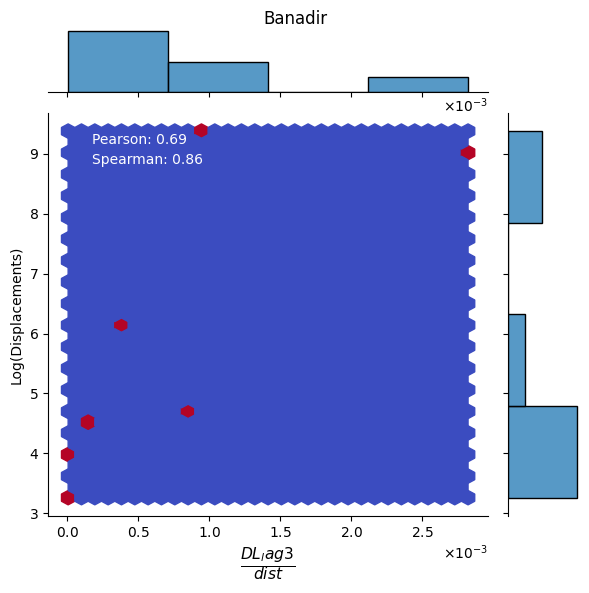

In [3]:
j = 'Banadir'
regions = df_d['admin1'].unique()
region_codes = pd.factorize(regions)[0]
cmap = plt.cm.get_cmap('tab20', len(regions))

lag = 'DL_lag3'
lag_str = 'DL_{lag3}'
vec_region = []
df_j=[]
year = 2022
disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
        
month =2
            
disp_reg = disp_matxs_i[j]
disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
disp_reg['inv_dist'] = inv_distance[j]
df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month)].reset_index()
disp_reg[lag] = df_m_y[lag]
disp_reg = disp_reg[disp_reg[j]!=0]

vec_region.append(disp_reg)

df_j = pd.concat(vec_region, ignore_index=True)
df_j = df_j[np.isfinite(df_j[lag]*df_j['inv_dist']**2)]

if len(df_j[j]) >= 2:
    corr_pearson, p_value = pearsonr(df_j['DL_lag3']*df_j['inv_dist']**2, df_j[j])
    corr_spearman, _ = spearmanr(df_j[lag]*df_j['inv_dist']**2, df_j[j])
else:
    corr_pearson = np.nan
    corr_spearman = np.nan
df_j[j] = np.log(df_j[j])
df_j['x'] = df_j[lag]*df_j['inv_dist']**2

g = sns.jointplot(data=df_j, x='x', y=j, kind='hex', cmap='coolwarm', joint_kws={'gridsize': 30})
g.ax_joint.set_xlabel(fr'$\frac{{DL_lag3}}{{dist}}$', fontsize=16)
g.ax_joint.set_ylabel('Log(Displacements)')
g.fig.suptitle(j)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)
g.ax_joint.text(0.1, 0.95, f"Pearson: {corr_pearson:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')
g.ax_joint.text(0.1, 0.9, f"Spearman: {corr_spearman:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-1, 1))
g.ax_joint.xaxis.set_major_formatter(formatter)
print(p_value)

In [4]:
month = 2
y_22= disp_matxs[(disp_matxs['year'] == 2022)]
y_22_1 = y_22[(18*month):(18*month +18)]
y_22_1.drop(columns=['year'], inplace=True)

#sum all columns for each row
#print(y_22.sum(axis=1))
print(y_22.sum(axis=0))


Current (Arrival) Region
Awdal                8457
Bakool              92486
Banadir            305173
Bari                55901
Bay                170073
Galgaduud          129509
Gedo               105910
Hiraan               2727
Lower Juba          58952
Lower Shabelle      17348
Middle Juba         24028
Middle Shabelle     12093
Mudug              106024
Nugaal              10162
Sanaag              12382
Sool                19011
Togdheer            60706
Woqooyi Galbeed      1529
year               436752
dtype: int64


/tmp/ipykernel_24844/2857165769.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_22_1.drop(columns=['year'], inplace=True)


In [5]:
regions = df_d['admin1'].unique()
region_codes = pd.factorize(regions)[0]
cmap = plt.cm.get_cmap('tab20', len(regions))

disp_matxs['year'] = disp_matxs.index.get_level_values('time').year
vac_lag = ['DL', 'DL_lag1', 'DL_lag2', 'DL_lag3', 'DL_lag4', 'DL_lag5']
lag_str = ['DL', 'DL_{lag1}', 'DL_{lag2}', 'DL_{lag3}', 'DL_{lag4}', 'DL_{lag5}']

/tmp/ipykernel_24844/1657199382.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(regions))


## Scatter plot 

$$
Disp_{ji} = f(\frac{DL_{lag2, i}}{dist^2_{ji}})
$$


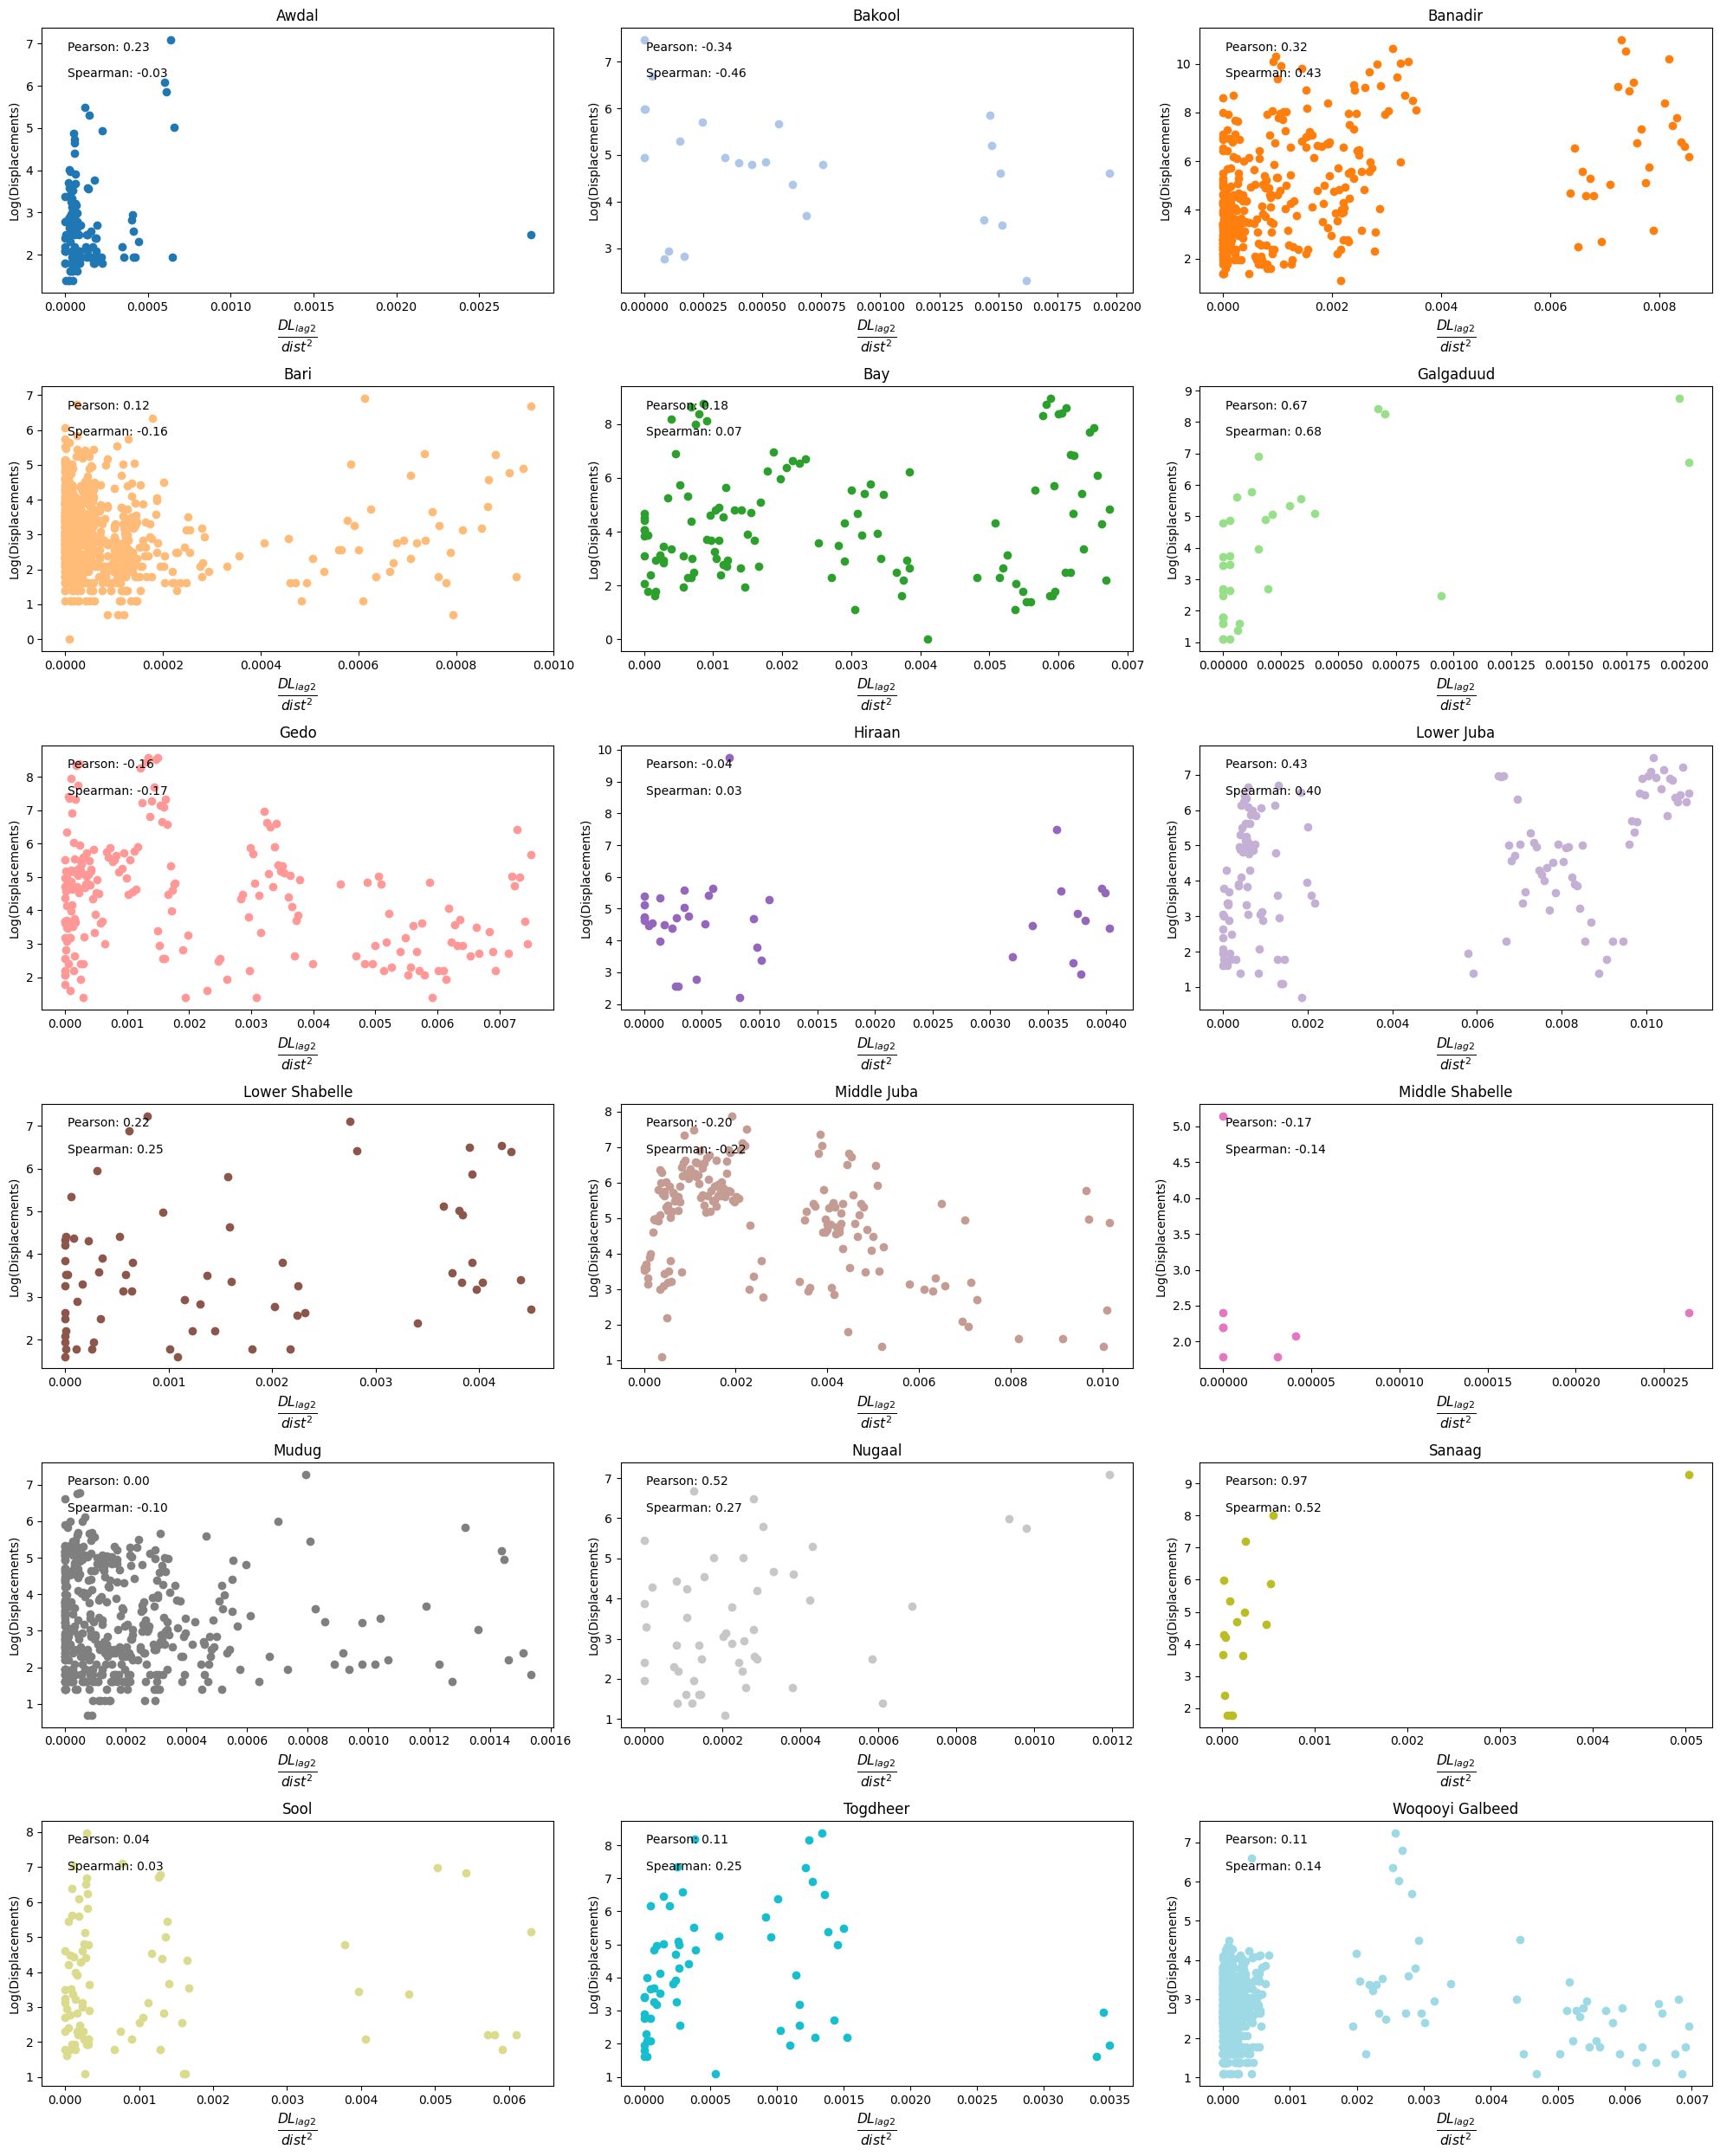

In [6]:
fig, axs = plt.subplots(6, 3, figsize=(20, 25))  

for i, j in enumerate(regions):
    row = i // 3  # Calculate the row index for the current region
    col = i % 3  # Calculate the column index for the current region
    vec_region = []

    for year in range(2016, 2023):
        disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
        
        for month in range(12):
            
            disp_reg = disp_matxs_i[j]
            disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
            disp_reg['inv_dist'] = inv_distance[j]
            df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month)].reset_index()
            disp_reg['DL_lag2'] = df_m_y['DL_lag2']
            disp_reg = disp_reg[disp_reg[j]!=0]
            color = cmap(region_codes[regions == j][0])
            axs[row, col].scatter(disp_reg['DL_lag2']*disp_reg['inv_dist']**2, np.log(disp_reg[j]), color=color)
        
            vec_region.append(disp_reg)

    df_j = pd.concat(vec_region, ignore_index=True)
    df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['inv_dist']*df_j['DL_lag2'])]
    df_j = df_j[df_j['inv_dist']*df_j['inv_dist']*df_j['DL_lag2'] != np.nan]

    
    if len(df_j[j]) >= 2:
        corr_pearson, _ = pearsonr(df_j['DL_lag2']*df_j['inv_dist']**2, df_j[j])
        corr_spearman, _ = spearmanr(df_j['DL_lag2']*df_j['inv_dist']**2, df_j[j])
    else:
        corr_pearson = np.nan
        corr_spearman = np.nan

    axs[row, col].set_xlabel(fr'$\frac{{{lag_str[2]}}}{{dist^2}}$', fontsize=16)
    axs[row, col].set_ylabel('Log(Displacements)')
    axs[row, col].set_title(j)
    axs[row, col].text(0.05, 0.95, f"Pearson: {corr_pearson:.2f}", transform=axs[row, col].transAxes, ha='left', va='top')
    axs[row, col].text(0.05, 0.85, f"Spearman: {corr_spearman:.2f}", transform=axs[row, col].transAxes, ha='left', va='top')
    
plt.tight_layout()
plt.show()

## Jointplot 

$$
Log(Disp_{ji}) = f(\frac{DL_{lag2, i}}{dist_{ji}})
$$

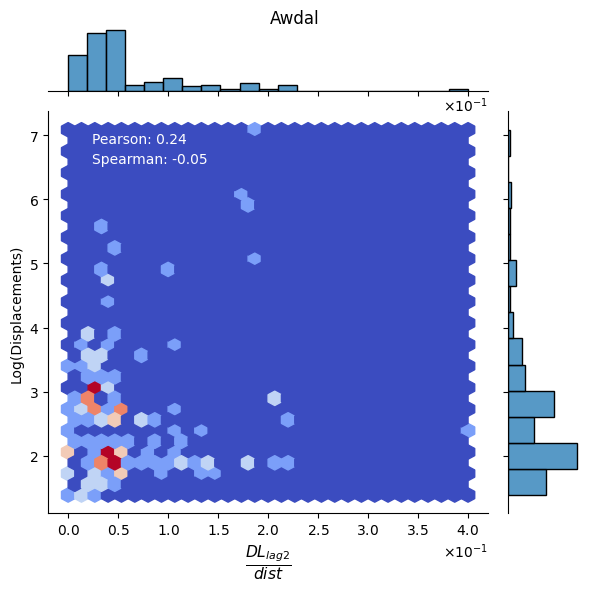

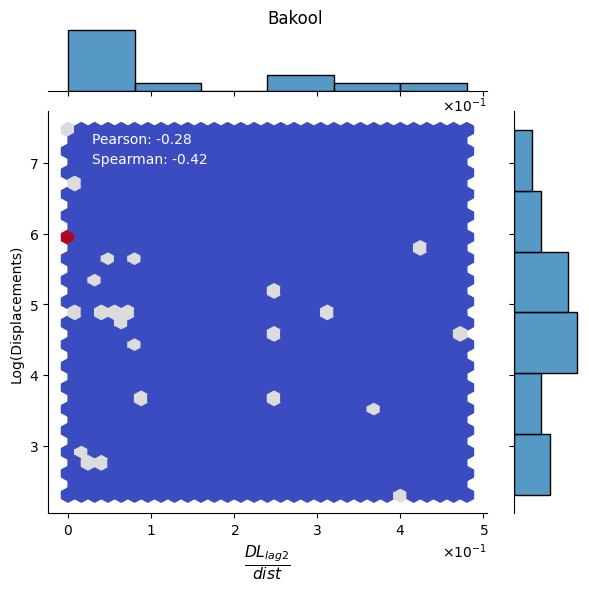

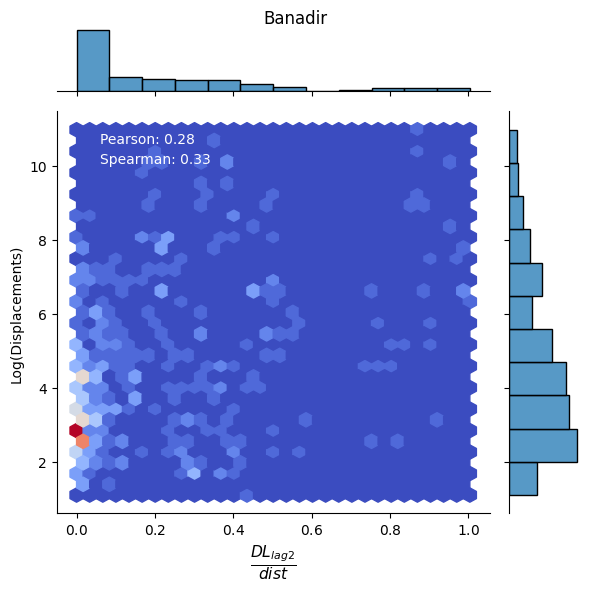

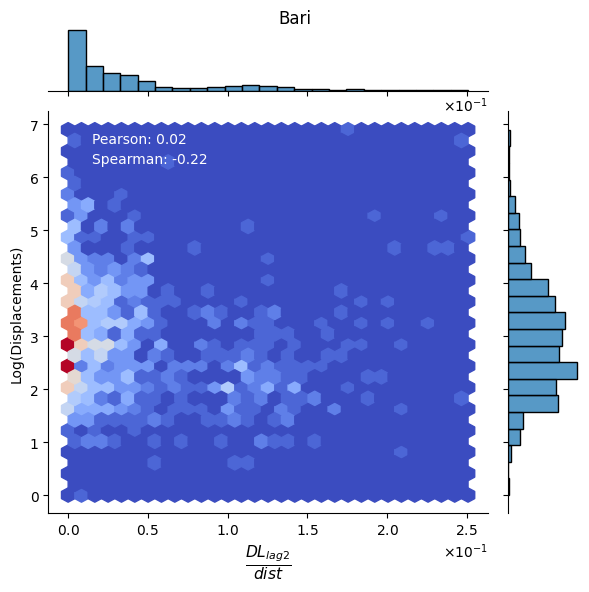

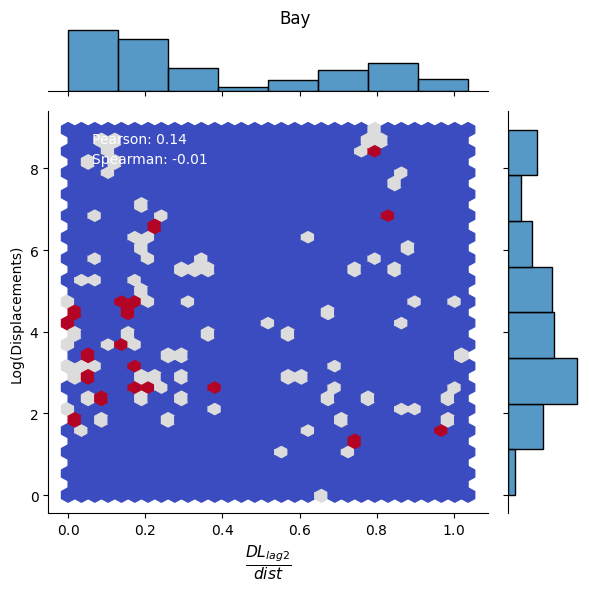

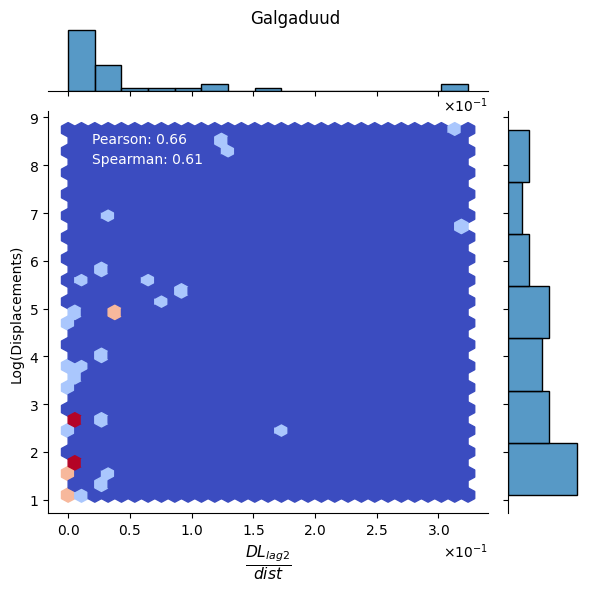

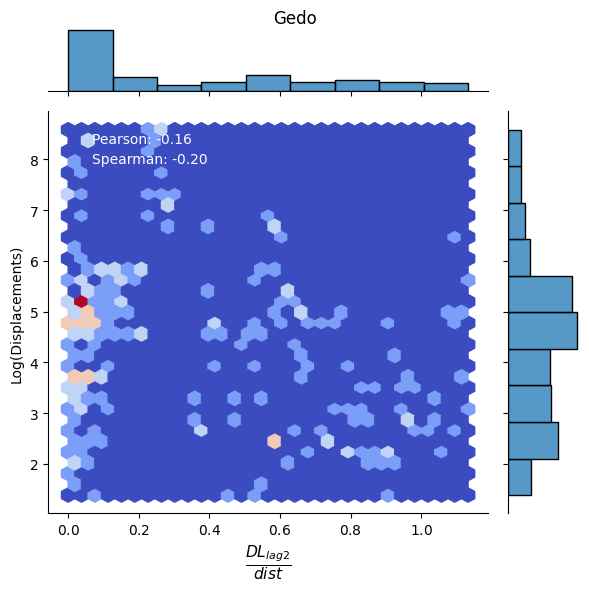

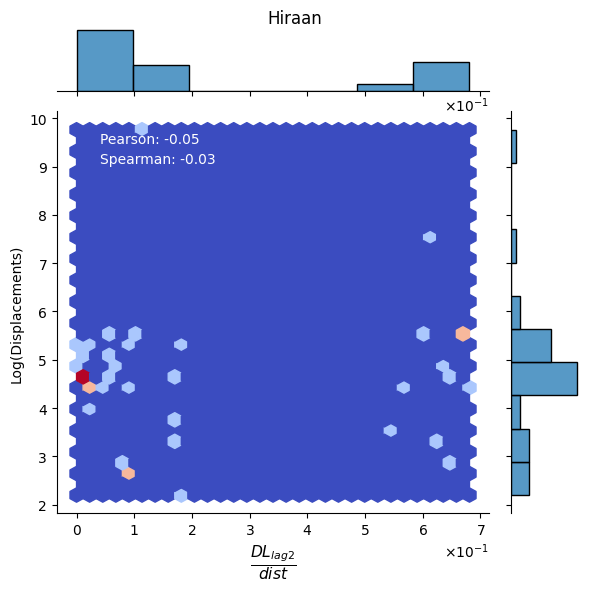

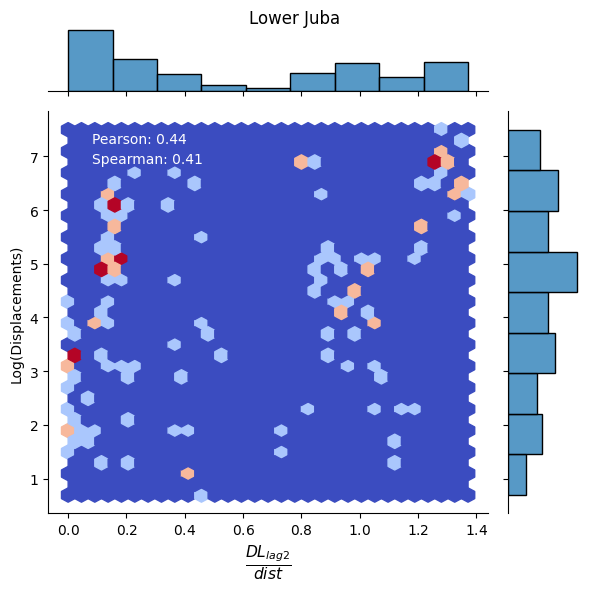

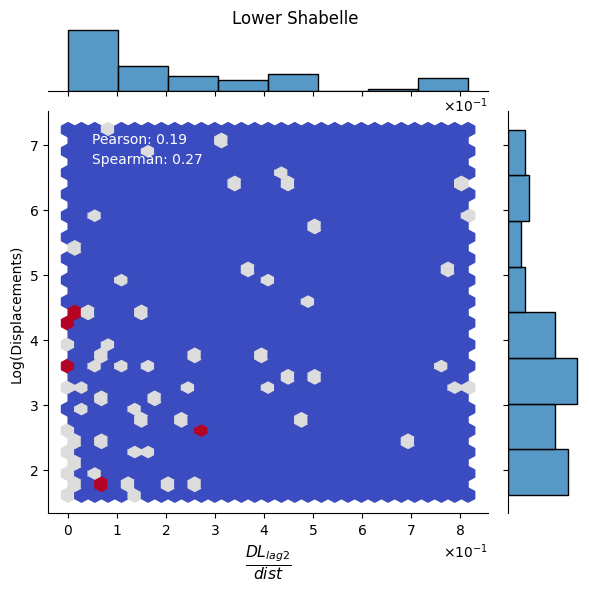

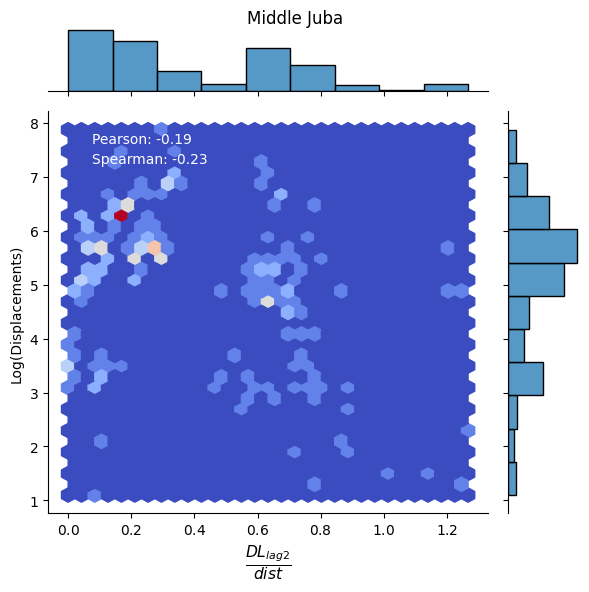

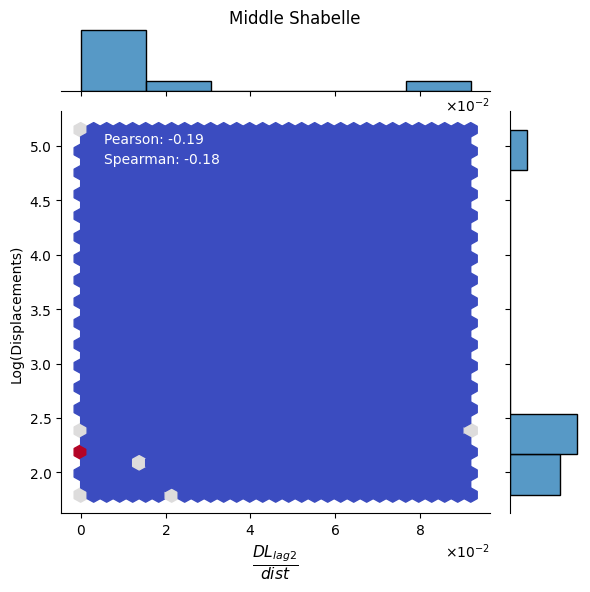

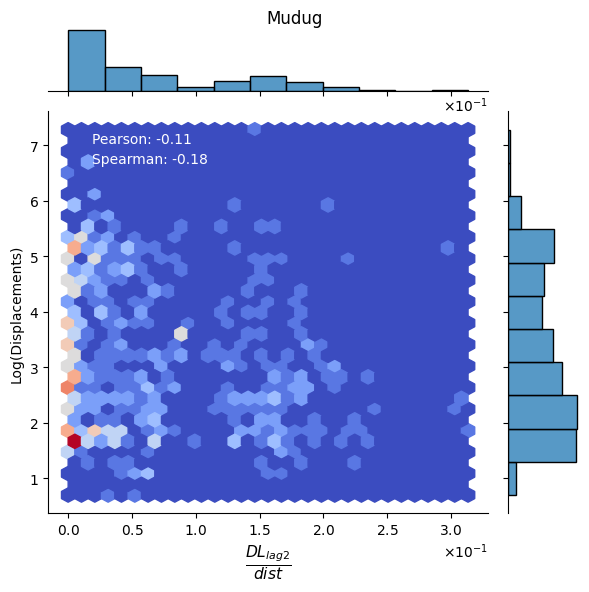

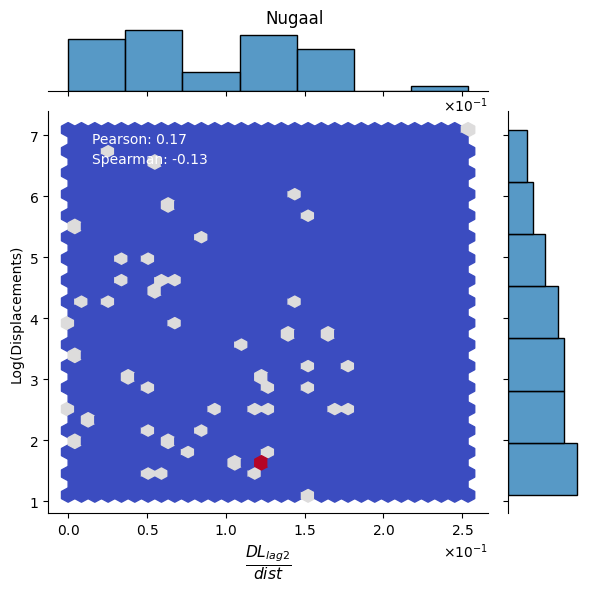

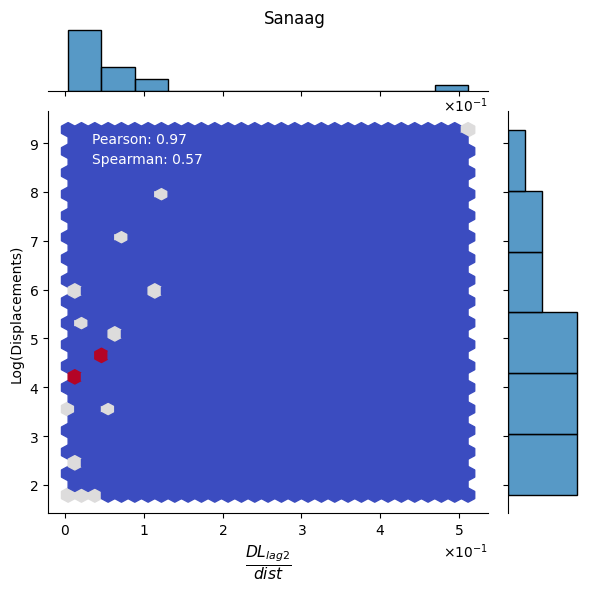

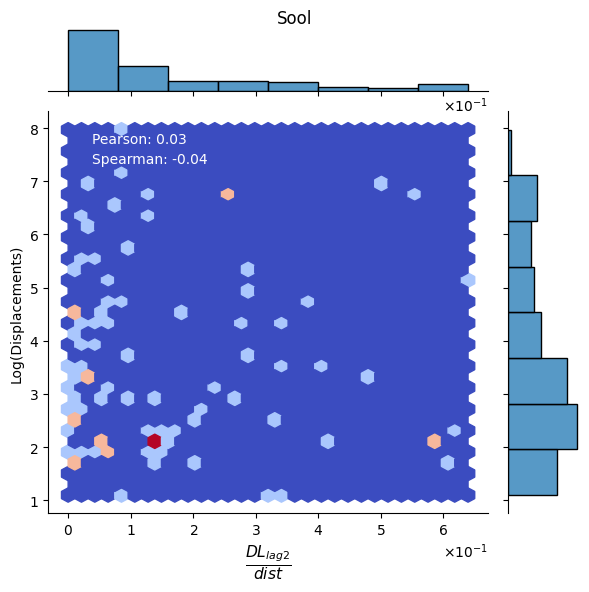

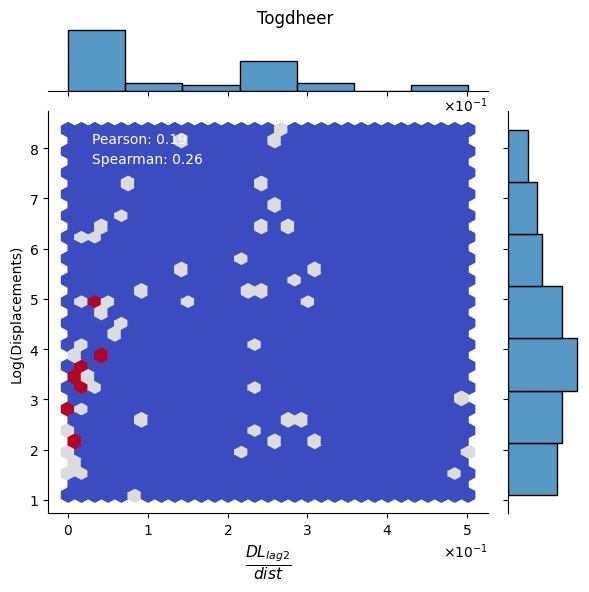

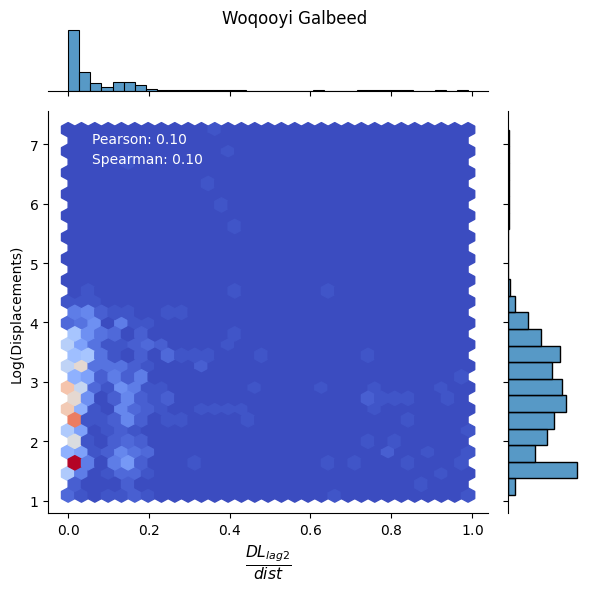

In [7]:
for i, j in enumerate(regions):
    row = i // 3  # Calculate the row index for the current region
    col = i % 3  # Calculate the column index for the current region
    vec_region = []
    df_j=[]

    for year in range(2016, 2023):
        disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
        
        for month in range(12):
            
            disp_reg = disp_matxs_i[j]
            disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
            disp_reg['inv_dist'] = inv_distance[j]
            df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month)].reset_index()
            disp_reg['DL_lag2'] = df_m_y['DL_lag2']
            disp_reg = disp_reg[disp_reg[j]!=0]
            
            vec_region.append(disp_reg)

    df_j = pd.concat(vec_region, ignore_index=True)
    df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['DL_lag2'])]

    if len(df_j[j]) >= 2:
        corr_pearson, _ = pearsonr(df_j['inv_dist']*df_j['DL_lag2'], df_j[j])
        corr_spearman, _ = spearmanr(df_j['inv_dist']*df_j['DL_lag2'], df_j[j])
    else:
        corr_pearson = np.nan
        corr_spearman = np.nan
    df_j[j] = np.log(df_j[j])
    df_j['x'] = df_j['DL_lag2']*df_j['inv_dist']

    g = sns.jointplot(data=df_j, x='x', y=j, kind='hex', cmap='coolwarm', joint_kws={'gridsize': 30})
    g.ax_joint.set_xlabel(fr'$\frac{{{lag_str[2]}}}{{dist}}$', fontsize=16)
    g.ax_joint.set_ylabel('Log(Displacements)')
    g.fig.suptitle(j)
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)
    g.ax_joint.text(0.1, 0.95, f"Pearson: {corr_pearson:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')
    g.ax_joint.text(0.1, 0.9, f"Spearman: {corr_spearman:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-1, 1))
    g.ax_joint.xaxis.set_major_formatter(formatter)
    
plt.show()

## Jointplot 

$$
Log(Disp_{ji}) = f(\frac{DL_i}{dist^2_{ji}})
$$

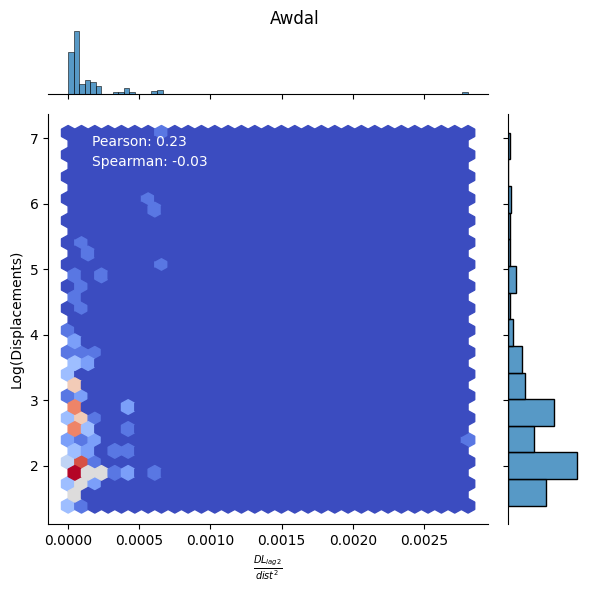

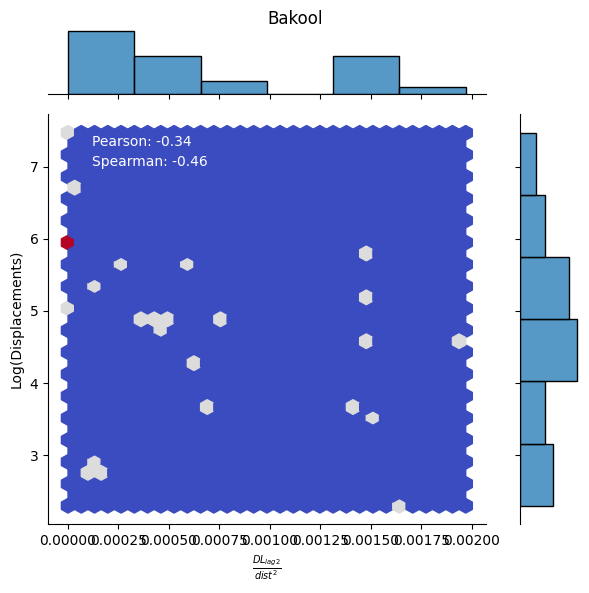

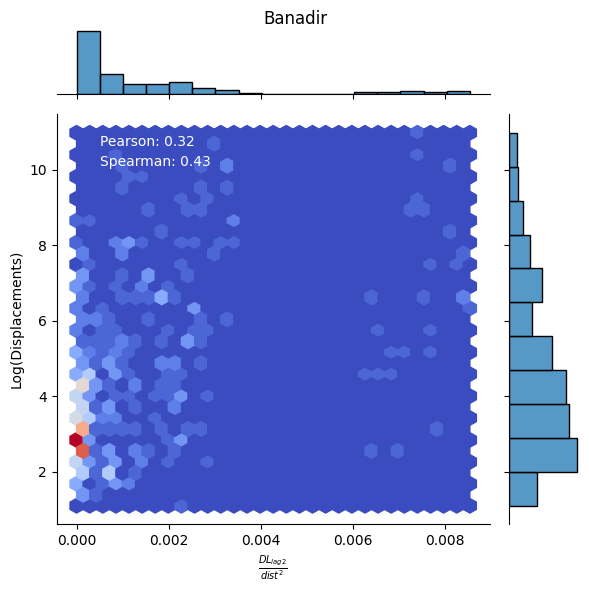

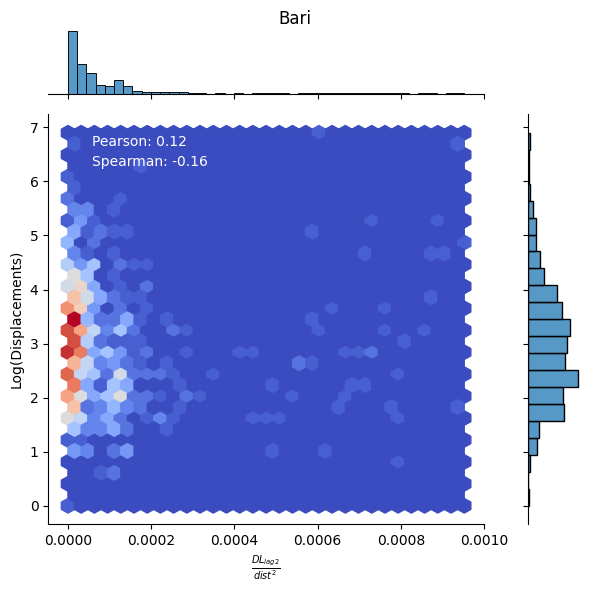

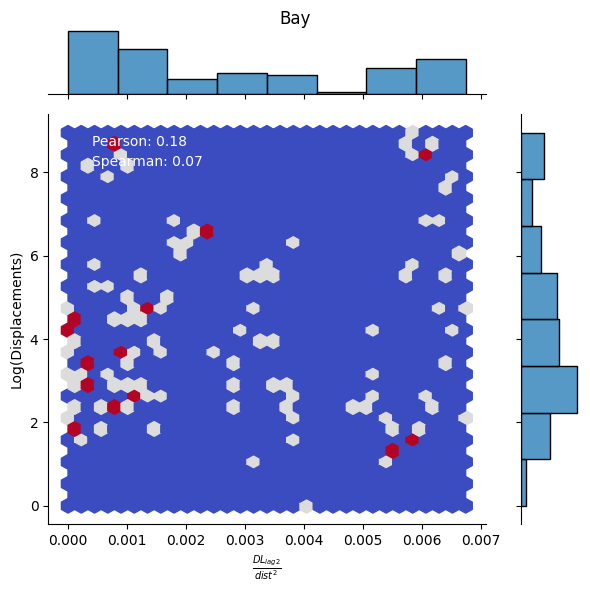

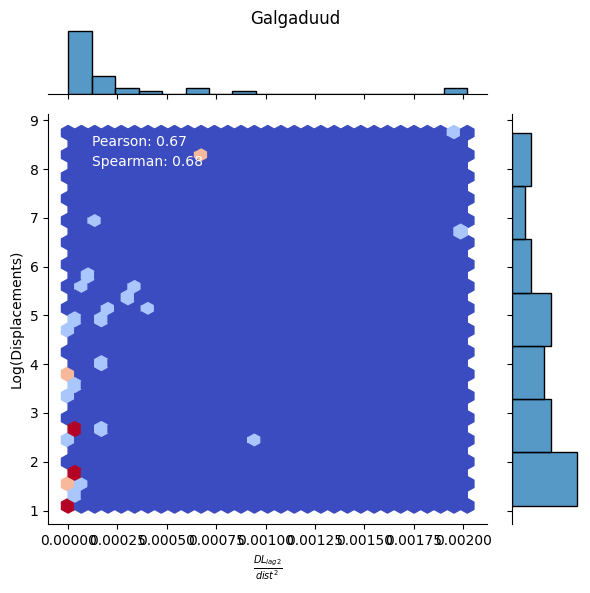

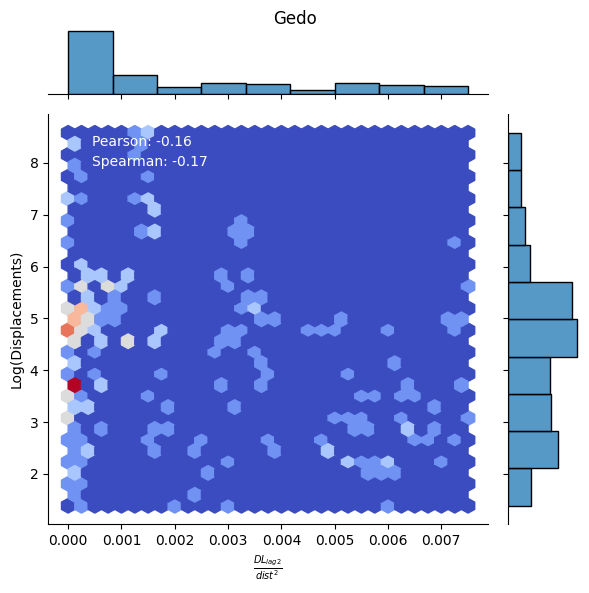

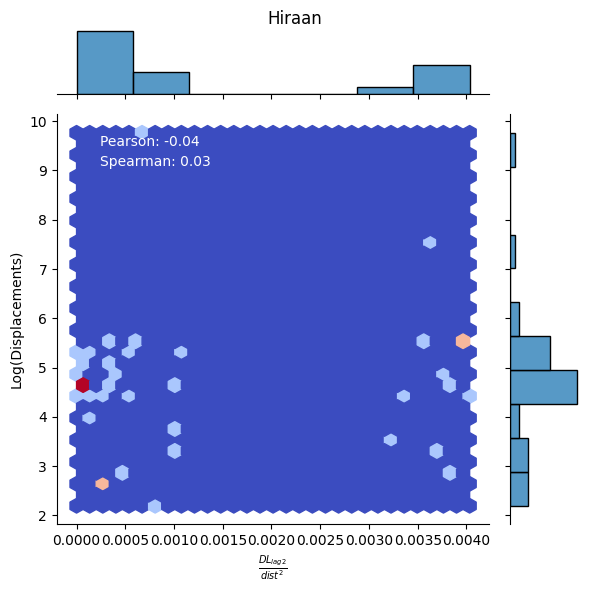

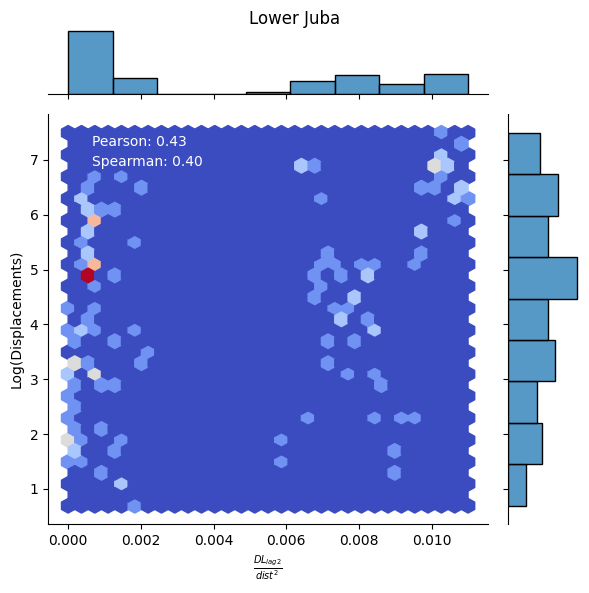

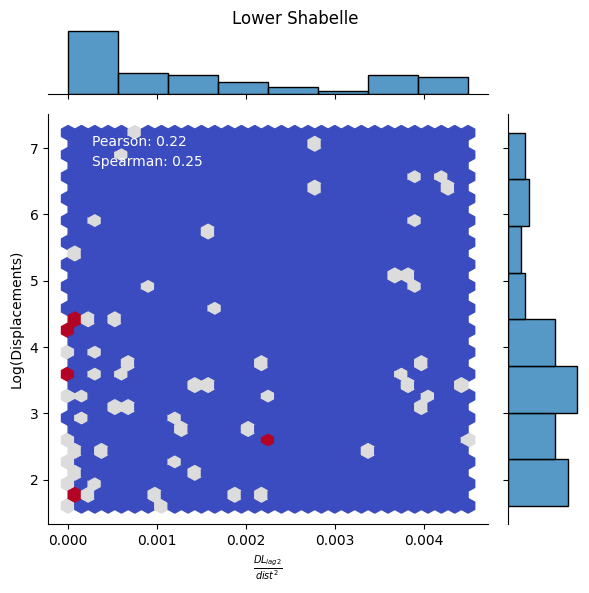

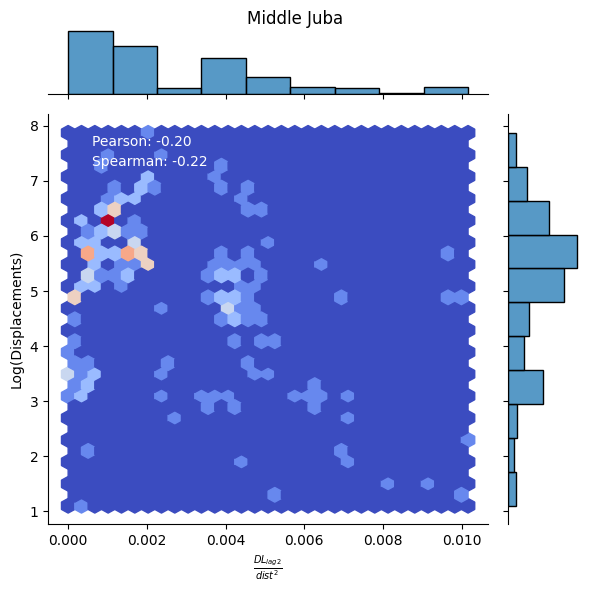

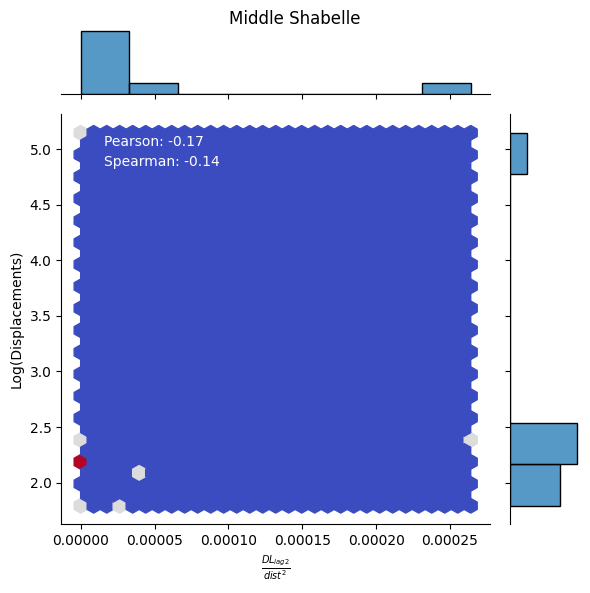

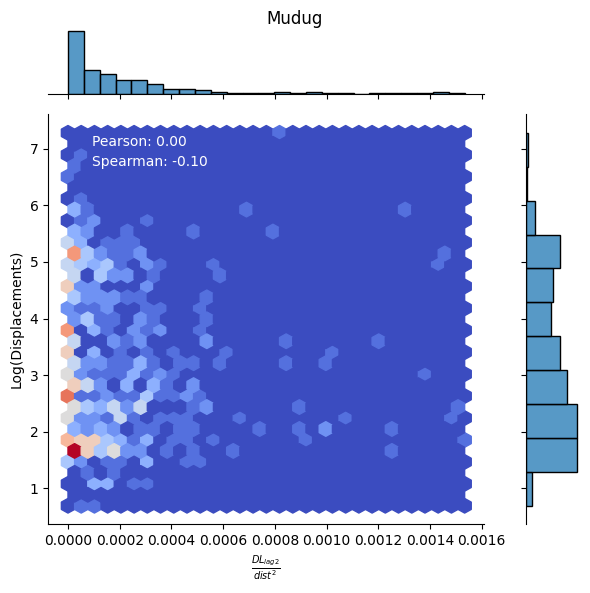

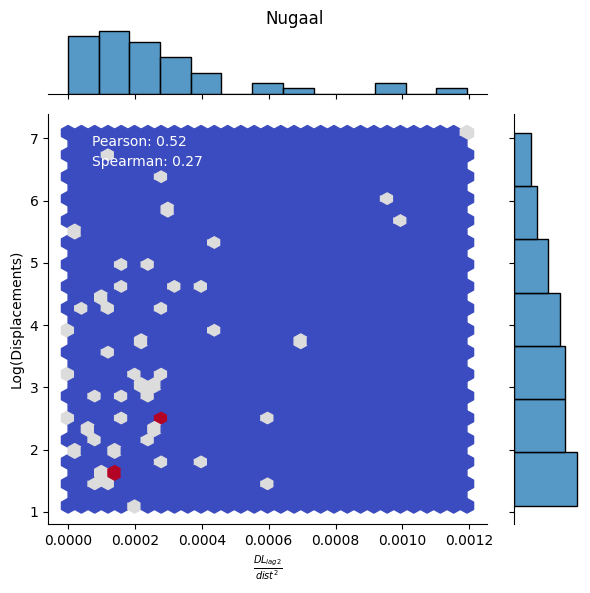

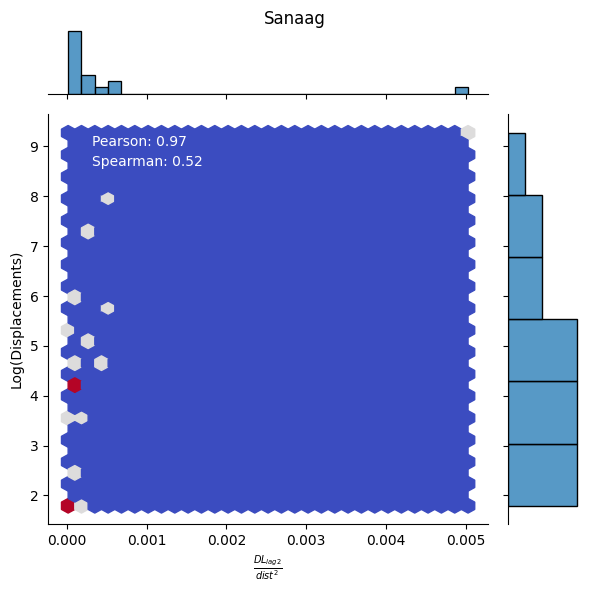

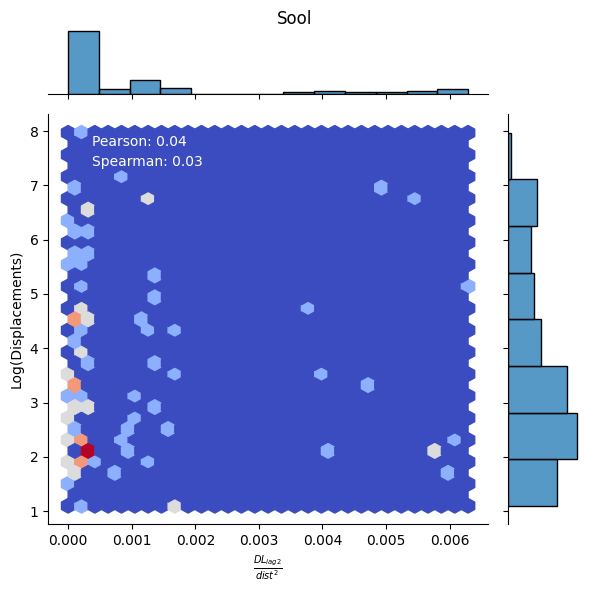

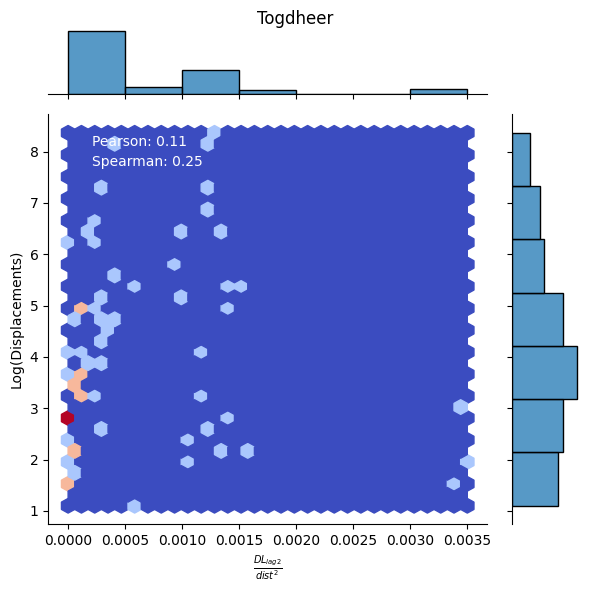

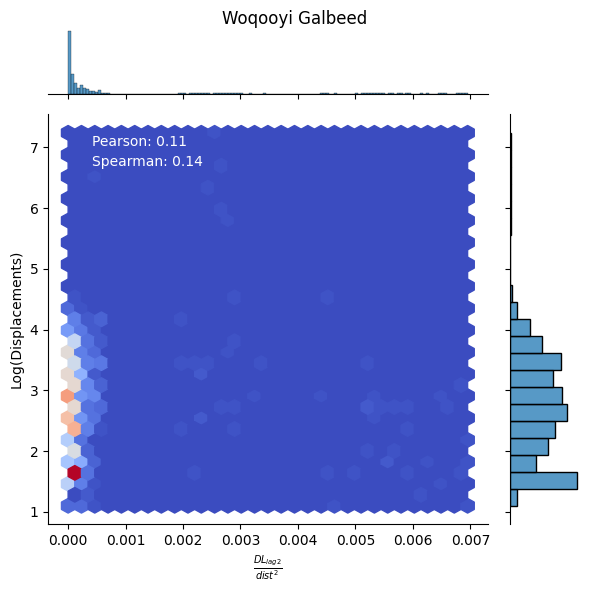

In [8]:
for i, j in enumerate(regions):
    row = i // 3  # Calculate the row index for the current region
    col = i % 3  # Calculate the column index for the current region
    vec_region = []
    df_j=[]

    for year in range(2016, 2023):
        disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
        
        for month in range(12):
            
            disp_reg = disp_matxs_i[j]
            disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
            disp_reg['inv_dist'] = inv_distance[j]
            df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month)].reset_index()
            disp_reg['DL_lag2'] = df_m_y['DL_lag2']
            disp_reg = disp_reg[disp_reg[j]!=0]
            
            vec_region.append(disp_reg)

    df_j = pd.concat(vec_region, ignore_index=True)
    df_j = df_j[np.isfinite(df_j['DL_lag2']*df_j['inv_dist']**2)]

    if len(df_j[j]) >= 2:
        corr_pearson, _ = pearsonr(df_j['DL_lag2']*df_j['inv_dist']**2, df_j[j])
        corr_spearman, _ = spearmanr(df_j['DL_lag2']*df_j['inv_dist']**2, df_j[j])
    else:
        corr_pearson = np.nan
        corr_spearman = np.nan
    df_j[j] = np.log(df_j[j])
    df_j['x'] = df_j['DL_lag2']*df_j['inv_dist']**2

    g = sns.jointplot(data=df_j, x='x', y=j, kind='hex', cmap='coolwarm', joint_kws={'gridsize': 30})
    g.ax_joint.set_xlabel(fr'$\frac{{{lag_str[2]}}}{{dist^2}}$')
    g.ax_joint.set_ylabel('Log(Displacements)')
    g.fig.suptitle(j)
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)
    g.ax_joint.text(0.1, 0.95, f"Pearson: {corr_pearson:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')
    g.ax_joint.text(0.1, 0.9, f"Spearman: {corr_spearman:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')

plt.show()

## Heatmap Pearson and spearman coefficient

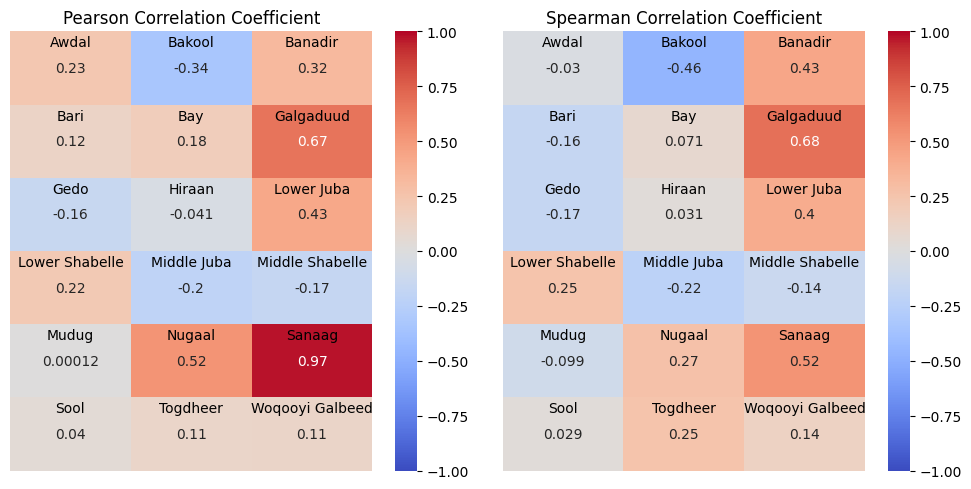

In [9]:
vec_corr_pearson = []
vec_corr_spearman = []

disp_matxs['year'] = disp_matxs.index.get_level_values('time').year

for j in regions:
    disp_reg_list = []
    
    for year in range(2016, 2023):
        disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
        
        for month in range(12):
            color = cmap(region_codes[regions == j][0])
            disp_reg = disp_matxs_i[j]
            disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
            disp_reg['inv_dist'] = inv_distance[j]
            df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month)].reset_index()
            disp_reg['DL_lag2'] = df_m_y['DL_lag2']
            disp_reg = disp_reg[disp_reg[j]!=0]

            disp_reg_list.append(disp_reg)

    df_j = pd.concat(disp_reg_list, ignore_index=True)
    df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['DL_lag2'])]

    if len(df_j[j]) >= 2:
        corr_pearson, _ = pearsonr(df_j['DL_lag2']*df_j['inv_dist']**2, df_j[j])
        corr_spearman, _ = spearmanr(df_j['DL_lag2']*df_j['inv_dist']**2, df_j[j])

        vec_corr_pearson.append(corr_pearson)
        vec_corr_spearman.append(corr_spearman)
    else:
        vec_corr_pearson.append(np.nan)
        vec_corr_spearman.append(np.nan)

vec_corr_pearson = np.array(vec_corr_pearson).reshape(6, 3)
vec_corr_spearman = np.array(vec_corr_spearman).reshape(6, 3)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

sns.heatmap(vec_corr_pearson, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=False, yticklabels=False, ax=ax1)
ax1.set_title('Pearson Correlation Coefficient')

sns.heatmap(vec_corr_spearman, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=False, yticklabels=False, ax=ax2)
ax2.set_title('Spearman Correlation Coefficient')

for i, j in enumerate(regions):
    row = i // 3  # row index 
    col = i % 3   # column index 
    ax1.text(col + 0.5, row + 0.15, f"{j}", ha='center', va='center', color='black', fontsize=10)
    ax2.text(col + 0.5, row + 0.15, f"{j}", ha='center', va='center', color='black', fontsize=10)

plt.tight_layout()
plt.show()

## Heatmap Pearson and Spearman (lags and regions)

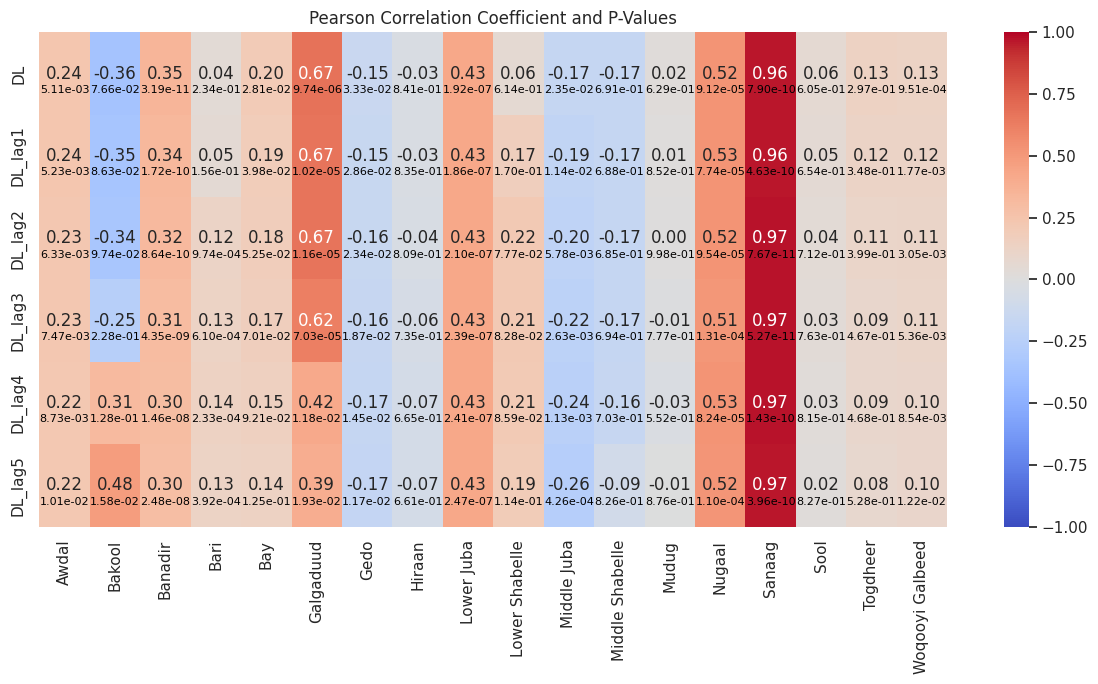

In [10]:
# Pearson coefficient heatmap

vec_corr_pearson = []
vec_p_values = []
disp_matxs['year'] = disp_matxs.index.get_level_values('time').year
reg_vec = ['DL', 'DL_lag1', 'DL_lag2', 'DL_lag3', 'DL_lag4', 'DL_lag5']

for DL_lag in reg_vec:

    for j in regions:
        disp_reg_list = []
        
        for year in range(2016, 2023):
            disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
            
            for month in range(12):
                color = cmap(region_codes[regions == j][0])
                disp_reg = disp_matxs_i[j]
                disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
                disp_reg['inv_dist'] = inv_distance[j]
                df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month)].reset_index()
                disp_reg['DL_lag_n'] = df_m_y[DL_lag]
                disp_reg = disp_reg[disp_reg[j]!=0]

                disp_reg_list.append(disp_reg)

        df_j = pd.concat(disp_reg_list, ignore_index=True)
        df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['DL_lag_n'])]

        if len(df_j[j]) >= 2:
            corr_pearson, p_value = pearsonr(df_j['DL_lag_n']*df_j['inv_dist']**2, df_j[j])
            vec_corr_pearson.append(corr_pearson)
            vec_p_values.append(p_value)
        else:
            vec_corr_pearson.append(np.nan)
            vec_p_values.append(np.nan)

vec_corr_pearson = np.array(vec_corr_pearson).reshape(6, 18)
vec_p_values = np.array(vec_p_values).reshape(6, 18)

sns.set(rc={'figure.figsize':(12,7)})
ax = sns.heatmap(vec_corr_pearson, annot=True, fmt='.2f', cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=regions, yticklabels=reg_vec)

# Add p-values to the heatmap
for i in range(vec_p_values.shape[0]):
    for j in range(vec_p_values.shape[1]):
        if not np.isnan(vec_p_values[i, j]):
            ax.text(j + 0.5, i + 0.7, f'{vec_p_values[i, j]:.2e}', ha='center', va='center', fontsize=8, color='black')

plt.title('Pearson Correlation Coefficient and P-Values')
plt.tight_layout()
plt.show()

In [11]:
vec_corr_pearson

array([[ 2.38794119e-01, -3.60630960e-01,  3.48372705e-01,
         4.47353665e-02,  1.99735680e-01,  6.72271439e-01,
        -1.45881252e-01, -3.37244998e-02,  4.28663841e-01,
         6.21786945e-02, -1.68368451e-01, -1.68172906e-01,
         2.29451016e-02,  5.24850874e-01,  9.61611337e-01,
         5.55556656e-02,  1.33517939e-01,  1.25623253e-01],
       [ 2.38220211e-01, -3.50021524e-01,  3.35890397e-01,
         5.33281913e-02,  1.87220158e-01,  6.71166311e-01,
        -1.50063124e-01, -3.48762826e-02,  4.29159297e-01,
         1.68477138e-01, -1.87736378e-01, -1.69822749e-01,
         8.89164188e-03,  5.29304003e-01,  9.64285271e-01,
         4.81642000e-02,  1.20228450e-01,  1.18910323e-01],
       [ 2.33036500e-01, -3.38939058e-01,  3.23379691e-01,
         1.23600365e-01,  1.76725026e-01,  6.67945309e-01,
        -1.55316810e-01, -4.05409886e-02,  4.27454106e-01,
         2.15409056e-01, -2.04397904e-01, -1.71354227e-01,
         1.19862614e-04,  5.23606286e-01,  9.71985094e

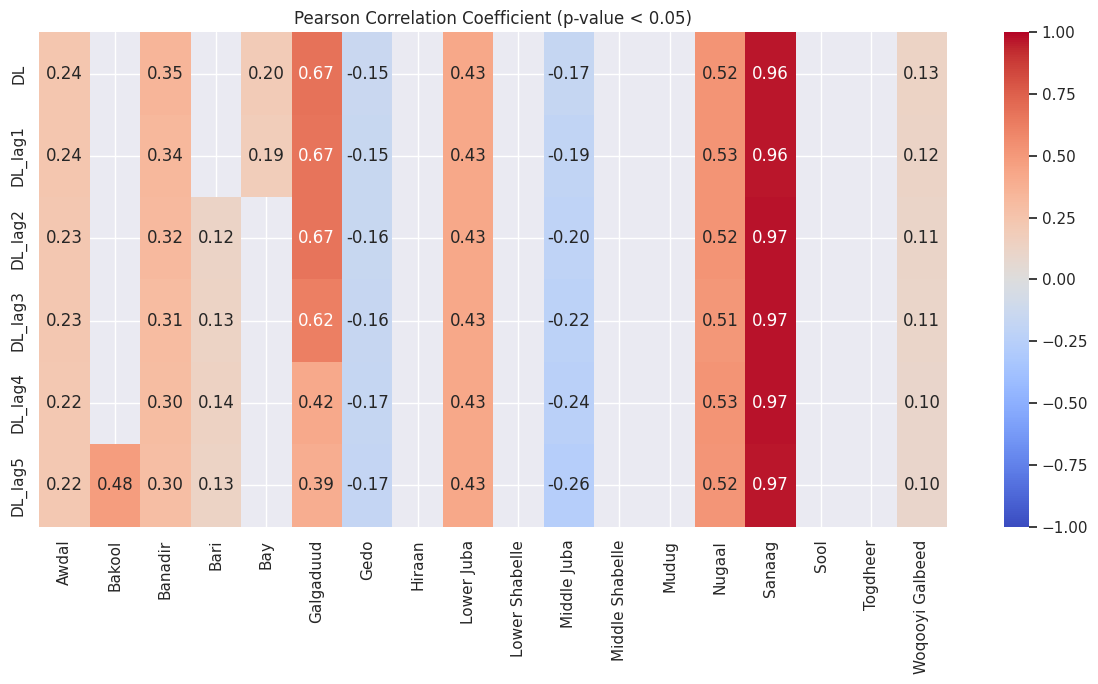

In [12]:
vec_corr_pearson = []
vec_p_values = []
disp_matxs['year'] = disp_matxs.index.get_level_values('time').year
reg_vec = ['DL', 'DL_lag1', 'DL_lag2', 'DL_lag3', 'DL_lag4', 'DL_lag5']

for DL_lag in reg_vec:

    for j in regions:
        disp_reg_list = []
        
        for year in range(2016, 2023):
            disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
            
            for month in range(12):
                color = cmap(region_codes[regions == j][0])
                disp_reg = disp_matxs_i[j]
                disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
                disp_reg['inv_dist'] = inv_distance[j]
                df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month)].reset_index()
                disp_reg['DL_lag_n'] = df_m_y[DL_lag]
                disp_reg = disp_reg[disp_reg[j]!=0]

                disp_reg_list.append(disp_reg)

        df_j = pd.concat(disp_reg_list, ignore_index=True)
        df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['DL_lag_n'])]

        if len(df_j[j]) >= 2:
            corr_pearson, p_value = pearsonr(df_j['DL_lag_n']*df_j['inv_dist']**2, df_j[j])
            vec_p_values.append(p_value)
            if p_value <= 0.05:
                vec_corr_pearson.append(corr_pearson)
            else:
                vec_corr_pearson.append(np.nan)
        else:
            vec_corr_pearson.append(np.nan)
            vec_p_values.append(np.nan)

vec_corr_pearson = np.array(vec_corr_pearson).reshape(6, 18)

sns.set(rc={'figure.figsize':(12,7)})
ax = sns.heatmap(vec_corr_pearson, annot=True, fmt='.2f', cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=regions, yticklabels=reg_vec)

plt.title('Pearson Correlation Coefficient (p-value < 0.05)')
plt.tight_layout()
plt.show()

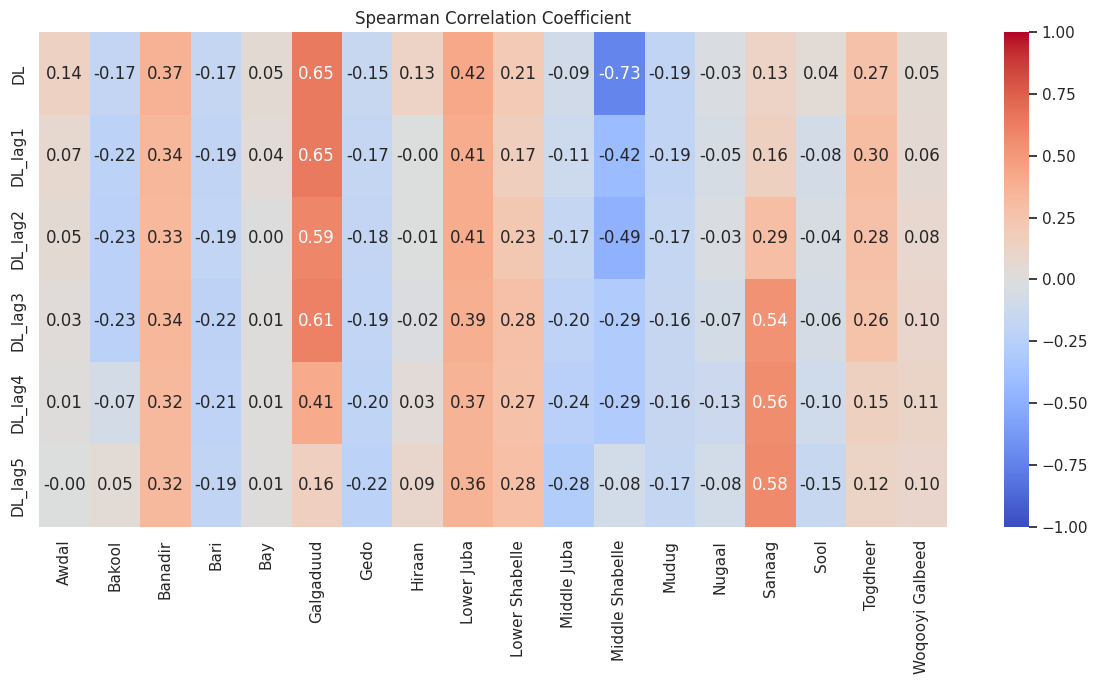

In [13]:
# Spearman coefficient heatmap

vec_corr_spearman = []
disp_matxs['year'] = disp_matxs.index.get_level_values('time').year
reg_vec = ['DL', 'DL_lag1', 'DL_lag2', 'DL_lag3', 'DL_lag4', 'DL_lag5']

for DL_lag in reg_vec:

    for j in regions:
        disp_reg_list = []
        
        for year in range(2016, 2023):
            disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
            
            for month in range(1, 13):
                color = cmap(region_codes[regions == j][0])
                disp_reg = disp_matxs_i[j]
                disp_reg = disp_reg[18*(month-1):18*(month +17)].reset_index()
                disp_reg['inv_dist'] = inv_distance[j]
                df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month)].reset_index()
                disp_reg['DL_lag_n'] = df_m_y[DL_lag]
                disp_reg = disp_reg[disp_reg[j]!=0]

                disp_reg_list.append(disp_reg)

        df_j = pd.concat(disp_reg_list, ignore_index=True)
        df_j = df_j[np.isfinite(df_j['DL_lag_n']*df_j['inv_dist']**2)]

        if len(df_j[j]) >= 2:
            corr_spearman, _ = spearmanr(df_j['inv_dist']*df_j['DL_lag_n'], df_j[j])
            vec_corr_spearman.append(corr_spearman)
        else:
            vec_corr_spearman.append(np.nan)

vec_corr_spearman = np.array(vec_corr_spearman).reshape(6, 18)
#increase cell size
sns.set(rc={'figure.figsize':(12,7)})
sns.heatmap(vec_corr_spearman, annot=True, fmt='.2f', cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=regions, yticklabels=reg_vec)
plt.title('Spearman Correlation Coefficient')
plt.tight_layout()
plt.show()

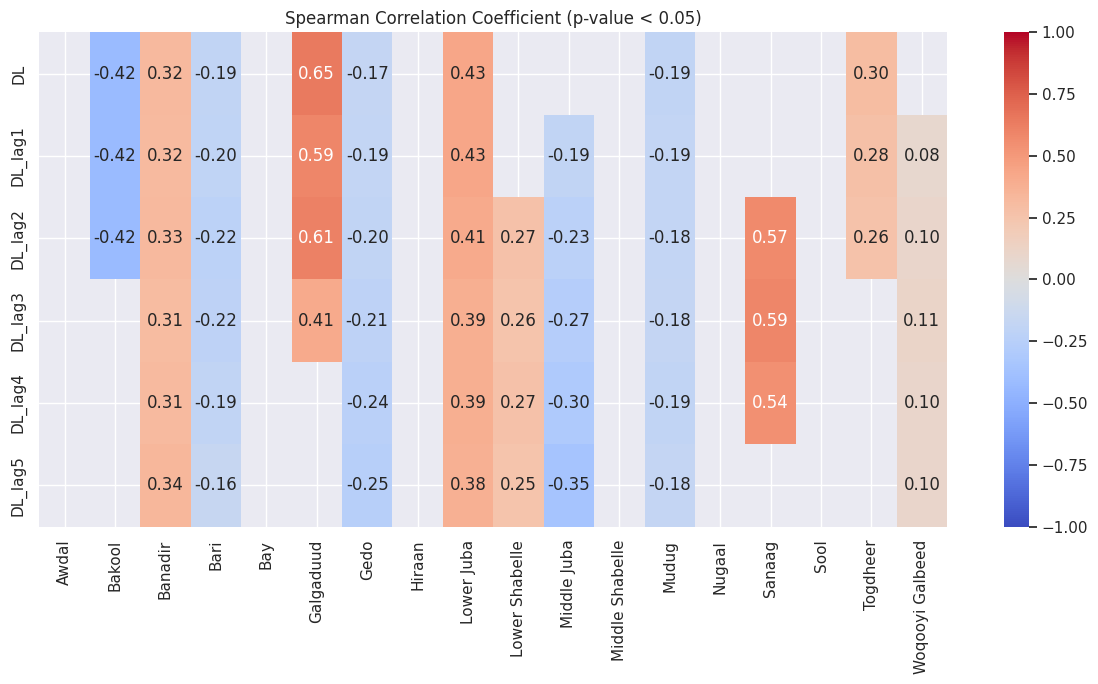

In [14]:
vec_corr_spearman = []
vec_p_values = []
disp_matxs['year'] = disp_matxs.index.get_level_values('time').year
reg_vec = ['DL', 'DL_lag1', 'DL_lag2', 'DL_lag3', 'DL_lag4', 'DL_lag5']

for DL_lag in reg_vec:

    for j in regions:
        disp_reg_list = []
        
        for year in range(2016, 2023):
            disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
            
            for month in range(12):
                color = cmap(region_codes[regions == j][0])
                disp_reg = disp_matxs_i[j]
                disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
                disp_reg['inv_dist'] = inv_distance[j]
                df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month)].reset_index()
                disp_reg['DL_lag_n'] = df_m_y[DL_lag]
                disp_reg = disp_reg[disp_reg[j]!=0]

                disp_reg_list.append(disp_reg)

        df_j = pd.concat(disp_reg_list, ignore_index=True)
        df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['DL_lag_n'])]

        if len(df_j[j]) >= 2:
            corr_spearman, p_value = spearmanr(df_j['inv_dist']*df_j['DL_lag_n'], df_j[j])
            vec_p_values.append(p_value)
            if p_value <= 0.05:
                vec_corr_spearman.append(corr_spearman)
            else:
                vec_corr_spearman.append(np.nan)
        else:
            vec_corr_spearman.append(np.nan)
            vec_p_values.append(np.nan)

vec_corr_spearman = np.array(vec_corr_spearman).reshape(6, 18)

sns.set(rc={'figure.figsize':(12,7)})
ax = sns.heatmap(vec_corr_spearman, annot=True, fmt='.2f', cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=regions, yticklabels=reg_vec)

plt.title('Spearman Correlation Coefficient (p-value < 0.05)')
plt.tight_layout()
plt.show()

## Jointplot for Banadir region with different lags

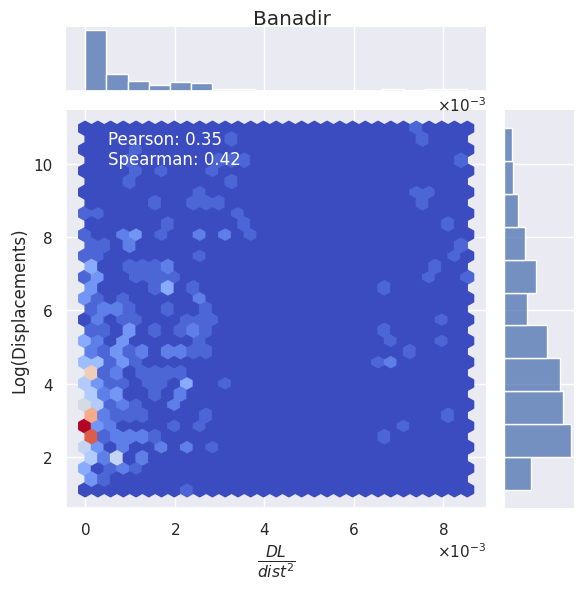

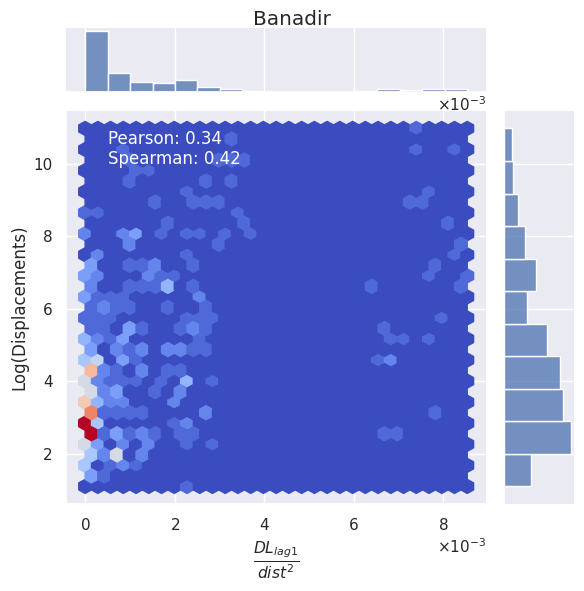

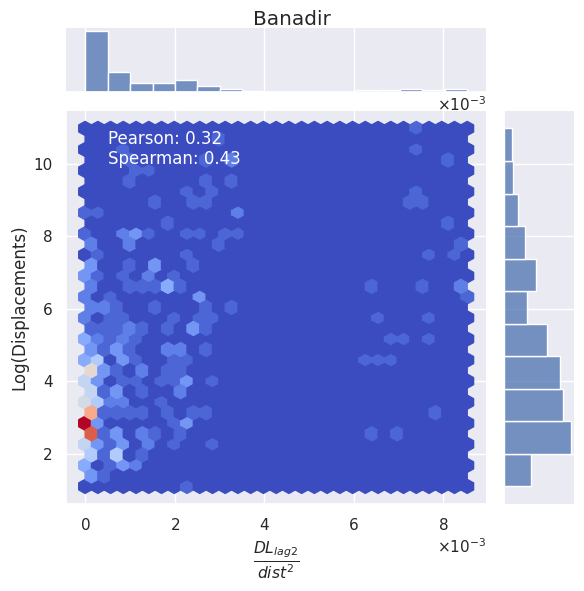

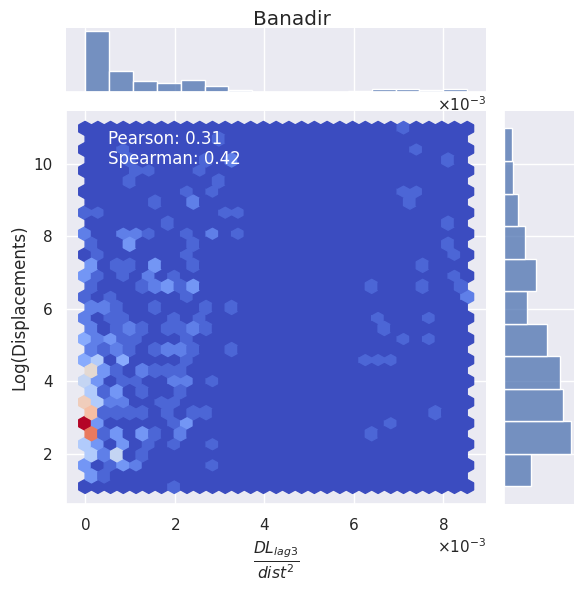

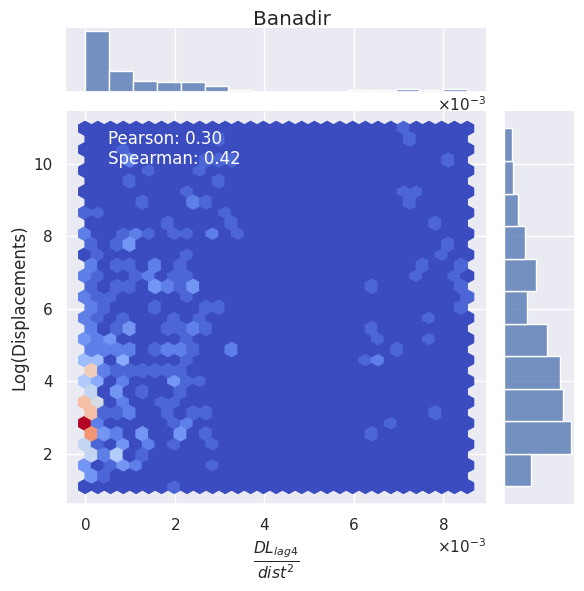

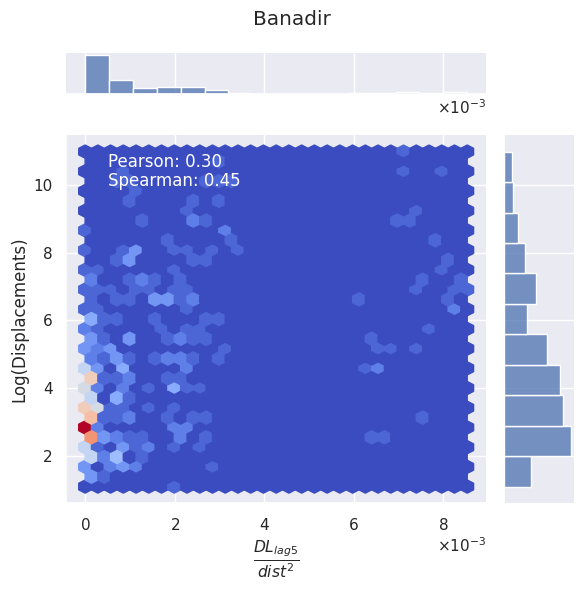

In [15]:
j = 'Banadir'
color = cmap(region_codes[regions == j][0])

for i, lag in enumerate(vac_lag):

    vec_region = []
    df_j=[]

    for year in range(2016, 2023):
        disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
        
        for month in range(12):
            
            disp_reg = disp_matxs_i[j]
            disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
            disp_reg['inv_dist'] = inv_distance[j]
            df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month)].reset_index()
            disp_reg[lag] = df_m_y[lag]
            disp_reg = disp_reg[disp_reg[j]!=0]
            
            vec_region.append(disp_reg)

    df_j = pd.concat(vec_region, ignore_index=True)
    df_j = df_j[np.isfinite(df_j[lag]*df_j['inv_dist']**2)]

    if len(df_j[j]) >= 2:
        corr_pearson, _ = pearsonr(df_j[lag]*df_j['inv_dist']**2, df_j[j])
        corr_spearman, _ = spearmanr(df_j[lag]*df_j['inv_dist']**2, df_j[j])
    else:
        corr_pearson = np.nan
        corr_spearman = np.nan
    df_j[j] = np.log(df_j[j])
    df_j['x'] = df_j[lag]*df_j['inv_dist']**2

    g = sns.jointplot(data=df_j, x='x', y=j, kind='hex', cmap='coolwarm', joint_kws={'gridsize': 30})
    g.fig.set_size_inches(6, 6)
    g.ax_joint.set_xlabel(fr'$\frac{{{lag_str[i]}}}{{dist^2}}$', fontsize=16)
    g.ax_joint.set_ylabel('Log(Displacements)')
    g.fig.suptitle(j)
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)
    g.ax_joint.text(0.1, 0.95, f"Pearson: {corr_pearson:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')
    g.ax_joint.text(0.1, 0.9, f"Spearman: {corr_spearman:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-1, 1))
    g.ax_joint.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()


    #pearson
    #spearman

    #heatmp con regioni per righe e lag per colonne con il coeff di correlazione, per vedere se colonne sono piu significative
    #prova anche con PA e DL
    #diverse funz di distanza
    #per tutte le regioni distinte
    #e con tutte le regioni insieme
    #anzichè scatter heatmap dei punti (vedi seaborn, slack) 
    #(colora i punti proporzionalmente alla DL della regione di arrivo)
    #

## Correlation

In [16]:
arrival = disp_data.groupby(['time','Current (Arrival) Region'])['Number of Individuals'].sum()

In [17]:
disp_data.head()

,time,Previous (Departure) Region,Current (Arrival) Region,Number of Individuals
0,2016-01-31,Bakool,Bakool,0
1,2016-01-31,Bakool,Banadir,0
2,2016-01-31,Bakool,Bari,0
3,2016-01-31,Bakool,Bay,14
4,2016-01-31,Bakool,Galgaduud,0


In [18]:
sum_dep = disp_data.groupby('Previous (Departure) Region')['Number of Individuals'].sum()
sum_dep= sum_dep.to_frame()

In [19]:
states_gdf = gpd.read_file(r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/som_adm_ocha_itos_20230308_shp/som_admbnda_adm1_ocha_20230308.shp")
states_gdf.head()

,Shape_Leng,Shape_Area,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry
0,5.657071,1.312224,Awdal,SO11,Somalia,SO,2022-12-21,2023-03-08,NaN,"MULTIPOLYGON (((43.46189 11.42429, 43.45532 11..."
1,6.650225,2.101389,Bakool,SO25,Somalia,SO,2022-12-21,2023-03-08,NaN,"POLYGON ((44.03028 4.95968, 44.08498 4.95730, ..."
2,1.068762,0.026612,Banadir,SO22,Somalia,SO,2022-12-21,2023-03-08,NaN,"POLYGON ((45.55389 2.15350, 45.55328 2.15308, ..."
3,12.218762,5.618064,Bari,SO16,Somalia,SO,2022-12-21,2023-03-08,NaN,"POLYGON ((50.79877 11.98356, 50.80576 11.97939..."
4,8.086913,3.572929,Bay,SO24,Somalia,SO,2022-12-21,2023-03-08,NaN,"POLYGON ((44.31110 3.57147, 44.31110 3.55957, ..."


In [20]:
merged_shp_anx_mob = sum_dep.merge(states_gdf, left_on='Previous (Departure) Region', right_on='ADM1_EN')
merged_shp_anx_mob.head()

,Number of Individuals,Shape_Leng,Shape_Area,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry
0,53184,5.657071,1.312224,Awdal,SO11,Somalia,SO,2022-12-21,2023-03-08,NaN,"MULTIPOLYGON (((43.46189 11.42429, 43.45532 11..."
1,421067,6.650225,2.101389,Bakool,SO25,Somalia,SO,2022-12-21,2023-03-08,NaN,"POLYGON ((44.03028 4.95968, 44.08498 4.95730, ..."
2,54654,1.068762,0.026612,Banadir,SO22,Somalia,SO,2022-12-21,2023-03-08,NaN,"POLYGON ((45.55389 2.15350, 45.55328 2.15308, ..."
3,176573,12.218762,5.618064,Bari,SO16,Somalia,SO,2022-12-21,2023-03-08,NaN,"POLYGON ((50.79877 11.98356, 50.80576 11.97939..."
4,921943,8.086913,3.572929,Bay,SO24,Somalia,SO,2022-12-21,2023-03-08,NaN,"POLYGON ((44.31110 3.57147, 44.31110 3.55957, ..."


AttributeError: module 'matplotlib.pyplot' has no attribute 'colors'

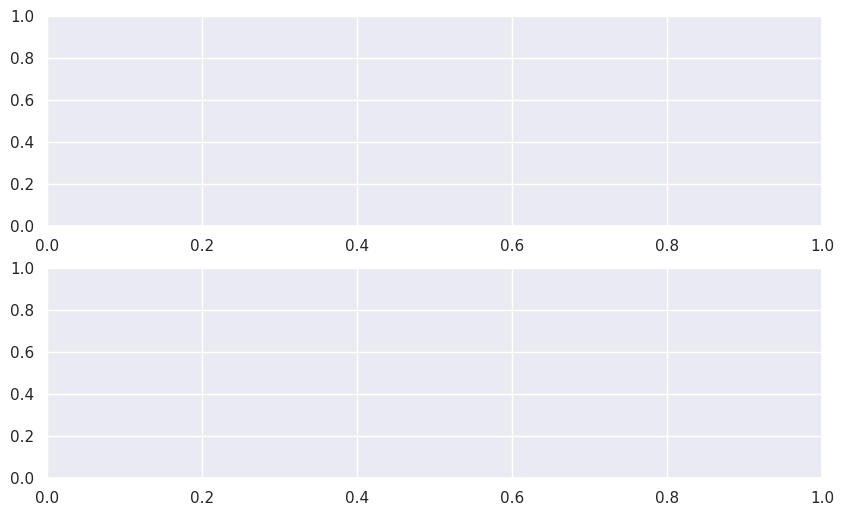

In [21]:
import matplotlib.patches as mpatches
# Merge the GeoDataFrame with the DataFrame containing state codes and numerical values
merged_shp_anx_mob = sum_dep.merge(states_gdf, left_on='Previous (Departure) Region', right_on='ADM1_EN')

cmap = 'coolwarm'

vmax=1; vmin=-1

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10,6))

ax1 = merged_shp_anx_mob.plot(
    column='corr',
    ax=ax[0],
    cmap=cmap,  # Use 'coolwarm' colormap for diverging colors from blue to red
    norm=plt.colors.Normalize(vmin=vmin, vmax=vmax),
    legend=None,
    legend_kwds={'label': "Mobility-Anxiety correlation", 'orientation': "vertical"},
)

ax[0].set_aspect(1.2)

ax2 = merged_shp_dep_mob.plot(
    column='corr',
    ax=ax[1],
    vmin=vmin, vmax=vmax,
    cmap=cmap,  # Use 'coolwarm' colormap for diverging colors from blue to red
    norm=plt.colors.Normalize(vmin=vmin, vmax=vmax),
    legend=None,
    legend_kwds={'label': "Mobility-Anxiety correlation", 'orientation': "vertical"},
)

# Legend
legend_patch = mpatches.Patch(color='#BBCBAC', label='p-val > 0.05')
ax[1].legend(handles=[legend_patch], loc='lower right', bbox_to_anchor=(1.1, 0.1))

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.colors.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])

fig.subplots_adjust(right=0.8)

ax[0].set_xlim(-130, -65)
ax[0].set_ylim(23, 50)

ax[1].set_xlim(-130, -65)
ax[1].set_ylim(23, 50)

ax[0].set_title('Feelings of Anxiety')
ax[1].set_title('Feelings of Depression')

ax[0].axis('off')
ax[1].axis('off')


cbar_axim = fig.add_axes([0.75, 0.27, 0.02, 0.5])
cbar = plt.colorbar(sm, shrink=0.5, cax=cbar_axim)
cbar.set_label('Spearman Correlation Coef.')

#plt.suptitle('Correlation with Mobility\n04/06 to 08/31', size=15,y=1, x=0.57)

plt.tight_layout() 

plt.savefig('mobility_mental_health_map.png')
plt.show()